In [46]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import shap

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load your preprocessed data

In [35]:
X = pd.read_csv('../data/model_input.csv')
X.head(3)

,PATIENT,AGE,GENDER,Body Mass Index,Left ventricular Ejection fraction,Systolic Blood Pressure,Heart rate,label
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,5,M,16.5,39.55,112.333333,102.4,False
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,6,F,16.2,39.55,120.000000,115.8,False
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,18,F,23.2,39.55,113.333333,100.7,False


In [36]:
# specify the columns we will use to train the model
exclude_columns = ['PATIENT', 'label']
include_columns = [col for col in X.columns if col not in exclude_columns]

# convert non-numeric columns to numeric
for column in include_columns:
    if X[column].dtype in ['O', str]:
        X[column] = X[column].astype('category')
        X[column] = X[column].cat.codes

X['label'] = X['label'].astype(int)

X

,PATIENT,AGE,GENDER,Body Mass Index,Left ventricular Ejection fraction,Systolic Blood Pressure,Heart rate,label
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,5,1,16.5,39.55,112.333333,102.400000,0
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,6,0,16.2,39.55,120.000000,115.800000,0
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,18,0,23.2,39.55,113.333333,100.700000,0
3,cc3c806f-4a09-4a89-a990-4286450956be,26,1,27.8,39.55,123.000000,72.200000,0
4,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,3,0,27.8,39.55,126.176471,108.923529,0
...,...,...,...,...,...,...,...,...
124145,1ecfda69-7afc-4417-8a6f-c00be1be96dc,88,1,27.3,36.55,122.000000,92.000000,1
124146,8cf835a7-f161-4fe9-a559-350c97a3450e,78,1,28.0,39.55,181.500000,57.450000,0
124147,503d768f-481c-46e2-bcdb-a6116686351a,88,1,27.9,39.55,119.352941,124.682353,0
124148,2599e9d9-ca59-44ec-a28c-9eae219f162d,88,1,27.9,39.00,121.000000,91.000000,1


# Split your dataset into training (70%) and testing (30%)

In [37]:
# set a random state to ensure reproducibility
random_state = 1

X_train, X_test, y_train, y_test = train_test_split(X[include_columns], X['label'], test_size=0.30, random_state=random_state)

# Model Training

## Train a logistic regression classifier with default settings
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [38]:
lr = LogisticRegression(random_state=random_state)
lr.fit(X_train, y_train)
y_pred_lr = lr.decision_function(X_test)

## Train a support vector machine (SVM) classifier with default settings
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [ ]:
svm = SVC(random_state=random_state)
svm.fit(X_train, y_train)
y_pred_svm = svm.decision_function(X_test)

## Train a random forest model with default settings
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

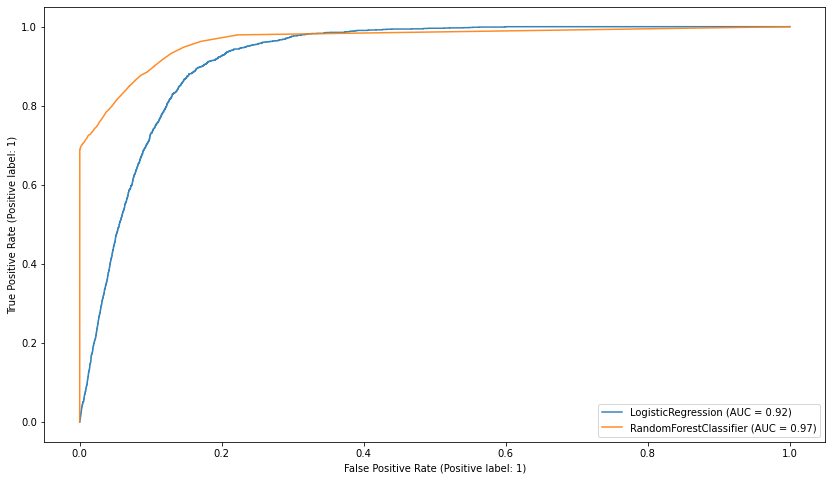

In [39]:
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# compare performance between the two

fig, ax = plt.subplots(figsize=(14, 8))
RocCurveDisplay.from_estimator(lr, X_test, y_test, ax=ax, alpha=0.9)
RocCurveDisplay.from_estimator(svm, X_test, y_test, ax=ax, alpha=0.9)
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, alpha=0.9)

# Compare the LR and RF classifiers
https://en.wikipedia.org/wiki/Confusion_matrix

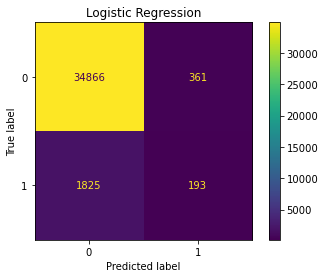

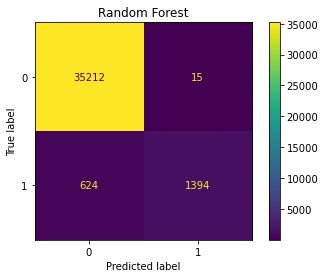

Random Forest,0,1
Logistic Regression,,
0,35429,1262
1,407,147


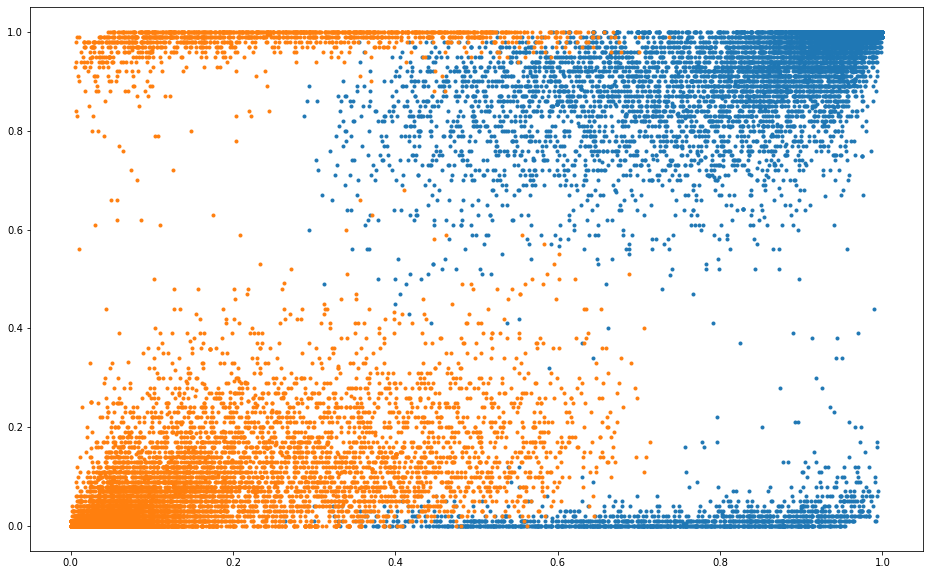

In [50]:
# confusion matrices
cm = confusion_matrix(y_test, y_pred_lr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
plt.title('Logistic Regression')
plt.show()

cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.title('Random Forest')
plt.show()

display(pd.crosstab(y_pred_lr, y_pred_rf, rownames=['Logistic Regression'], colnames=['Random Forest']))

y_pred_proba_lr = lr.predict_proba(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)

plt.figure(figsize=(16,10))
plt.plot(y_pred_proba_lr, y_pred_proba_rf, '.')
plt.show()

# Evaluate how the models work

## Feature importance

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
feature_names = [f"feature {i}" for i in range(X[include_columns].shape[1])]
forest_importances = pd.Series(result.importances_mean, index=include_columns)

plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(16,10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## SHAP
https://github.com/slundberg/shap

In [41]:
shap.initjs()

explainer = shap.TreeExplainer(rf)

chosen_instance = X_test.iloc[310]
shap_values = explainer.shap_values(chosen_instance)

shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_instance)

In [42]:
chosen_instance = X_test.loc[[79941]]
shap_values = explainer.shap_values(chosen_instance)

shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_instance)

In [45]:
explainer = shap.KernelExplainer(lr.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.loc[[79941]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])

X does not have valid feature names, but LogisticRegression was fitted with feature names
Using 86905 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|                                                    | 0/1 [00:00<?, ?it/s]X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
100%|████████████████████████████████████████████| 1/1 [00:14<00:00, 14.34s/it]


# Save model for later use

In [ ]:
from joblib import dump, load

dump(lr, 'lr_model_'+condition+'.pkl') 
dump(rf, 'rf_model_'+condition+'.pkl') 
